## A. Hexseg workflow: Hexagons

### 1. Load modules and data

In [1]:
import hexseg
import pyarrow.parquet as pq
import geopandas as gpd
from geopandas import GeoSeries
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
# Load datasets
# CRS
CRS_BNG = "EPSG:27700"

# Filepaths
pfa = "cleveland_police.parquet"
districts = "cleveland_districts.parquet"
roads = "cleveland_roads.parquet"
crimes = "sample_data.parquet"

# Helper function to read WKT-based GeoParquet
def read_wkt_parquet(path, crs=CRS_BNG, geom_col="geometry"):
    df = pq.read_table(path).to_pandas()
    gdf = gpd.GeoDataFrame(df, geometry=GeoSeries.from_wkt(df[geom_col]), crs=crs)
    return gdf

# Load datasets
gdf_pfa = read_wkt_parquet(pfa)
gdf_districts = read_wkt_parquet(districts)
gdf_roads = read_wkt_parquet(roads)
gdf_crimes = read_wkt_parquet(crimes)

### 2. get_hexagons

In [3]:
hexes = hexseg.get_hexagons(gdf_districts, name_col="lad21nm", resolution=9)

In [4]:
hexes

,hex_id,geo_boundary,geometry
0,891946453b3ffff,Stockton-on-Tees,"POLYGON ((437416.465 509936.224, 437274.298 50..."
1,8919464517bffff,Stockton-on-Tees,"POLYGON ((437945.717 509689.657, 437803.561 50..."
2,8919464514fffff,Stockton-on-Tees,"POLYGON ((437735.044 509961.363, 437592.884 50..."
3,8919464514bffff,Stockton-on-Tees,"POLYGON ((437524.371 510233.067, 437382.208 51..."
4,89194645397ffff,Stockton-on-Tees,"POLYGON ((437313.698 510504.771, 437171.533 51..."
...,...,...,...
6531,89194602447ffff,Redcar and Cleveland,"POLYGON ((478114.897 519186.034, 477973.695 51..."
6532,891946545c3ffff,Stockton-on-Tees,"POLYGON ((450334.936 525925.886, 450193.169 52..."
6533,89194644307ffff,Stockton-on-Tees,"POLYGON ((442605.232 508039.47, 442463.166 507..."
6534,89194656107ffff,Hartlepool,"POLYGON ((453834.727 527061.621, 453693.045 52..."


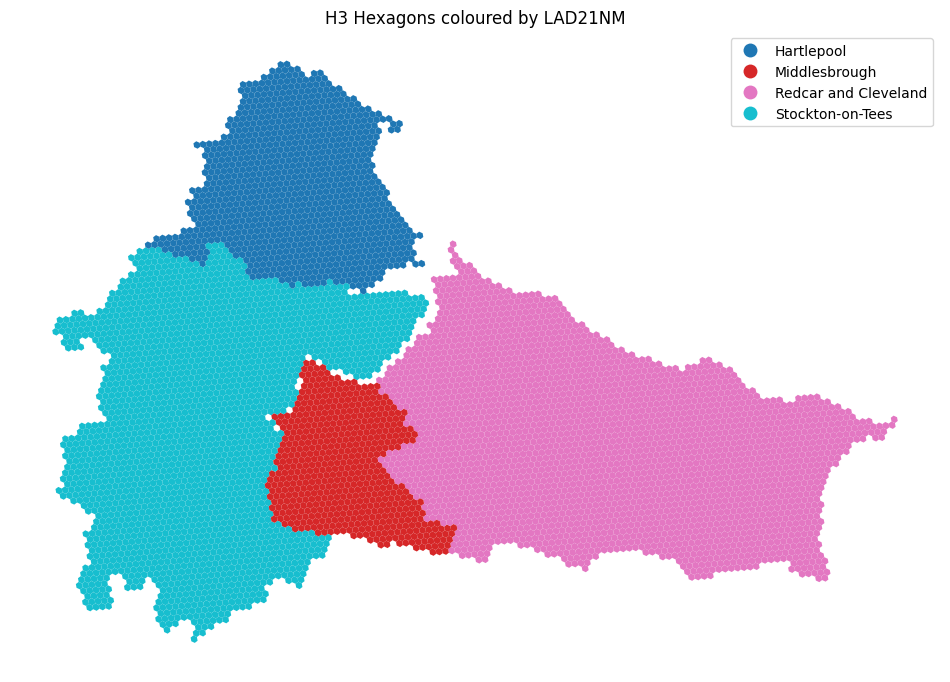

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))

hexes.plot(
    column="geo_boundary",    # this is your lad21nm field
    legend=True,      # show a legend tying colours to names
    linewidth=0.1,    # thin border so you can see each hexagon
    ax=ax
)

ax.set_title("H3 Hexagons coloured by LAD21NM")
ax.set_axis_off()

plt.show()

### 3. summarise_by_hex

* Summarise crime and/or weights data to hexagons

In [6]:
hex_both = hexseg.summarise_by_hex(
    hexes_gdf=hexes,
    crimes_gdf=gdf_crimes,
    count_col='any',
    weight_col='pseudo_harm'
    )

In [7]:
hex_both_sorted = hex_both.sort_values('crime_weight', ascending=False)
hex_both_sorted.head()

,hex_id,geo_boundary,geometry,crime_count,crime_weight
2247,89194654e17ffff,Middlesbrough,"POLYGON ((449461.285 520965.814, 449319.463 52...",702,323125.0
2188,89194654e33ffff,Middlesbrough,"POLYGON ((449564.202 520398.196, 449422.378 52...",726,177940.0
2144,89194654e3bffff,Middlesbrough,"POLYGON ((449246.245 520373.292, 449104.414 52...",438,114605.0
1291,89194655b83ffff,Stockton-on-Tees,"POLYGON ((444470.553 519135.401, 444328.608 51...",453,96455.0
4621,891946cd97bffff,Hartlepool,"POLYGON ((450689.062 532855.189, 450547.353 53...",491,88830.0


### 4. add_spatial_lag

* Optional, can add spatially lagged values or weights. This will create options to add the sum or mean of nearest neighbours (a 'donut' around the hex)

In [8]:
hex_lagged = hexseg.add_spatial_lag(
    hexes_gdf=hex_both,
    count_col='crime_count',
    weight_col='crime_weight',
    k=6
    )

In [9]:
hex_lagged_sorted = hex_lagged.sort_values('crime_weight', ascending=False)
hex_lagged_sorted.head()

,hex_id,geo_boundary,geometry,crime_count,crime_weight,lag_sum_count,lag_mean_count,count_plus_sum,count_plus_mean,lag_sum_weight,lag_mean_weight,weight_plus_sum_sqrt,weight_plus_mean_sqrt
2247,89194654e17ffff,Middlesbrough,"POLYGON ((449461.285 520965.814, 449319.463 52...",702,323125.0,720,120.000000,1422,822.000000,104105.0,17350.833333,653.628335,583.503071
2188,89194654e33ffff,Middlesbrough,"POLYGON ((449564.202 520398.196, 449422.378 52...",726,177940.0,1670,278.333333,2396,1004.333333,306565.0,51094.166667,696.063934,478.575142
2144,89194654e3bffff,Middlesbrough,"POLYGON ((449246.245 520373.292, 449104.414 52...",438,114605.0,1534,255.666667,1972,693.666667,346820.0,57803.333333,679.282710,415.220825
1291,89194655b83ffff,Stockton-on-Tees,"POLYGON ((444470.553 519135.401, 444328.608 51...",453,96455.0,1185,197.500000,1638,650.500000,218640.0,36440.000000,561.333234,364.547665
4621,891946cd97bffff,Hartlepool,"POLYGON ((450689.062 532855.189, 450547.353 53...",491,88830.0,1155,192.500000,1646,683.500000,255840.0,42640.000000,587.086024,362.587920


### 5. add_spatial_stats

* Optional, select a value column to be used in prioritising hexagons, a zscore will be created globally (entire study area) and locally (based on a geography filter, i.e. districts); and a rank order for each will be added (where 1 is highest)

In [10]:
hex_stats = hexseg.add_spatial_stats(hex_lagged, col='weight_plus_mean_sqrt', group_col='geo_boundary')

In [11]:
hex_stats.columns

Index(['hex_id', 'geo_boundary', 'geometry', 'crime_count', 'crime_weight',
       'lag_sum_count', 'lag_mean_count', 'count_plus_sum', 'count_plus_mean',
       'lag_sum_weight', 'lag_mean_weight', 'weight_plus_sum_sqrt',
       'weight_plus_mean_sqrt', 'weight_plus_mean_sqrt_zscore',
       'weight_plus_mean_sqrt_rank',
       'weight_plus_mean_sqrt_zscore_by_geo_boundary',
       'weight_plus_mean_sqrt_rank_by_geo_boundary'],
      dtype='object')

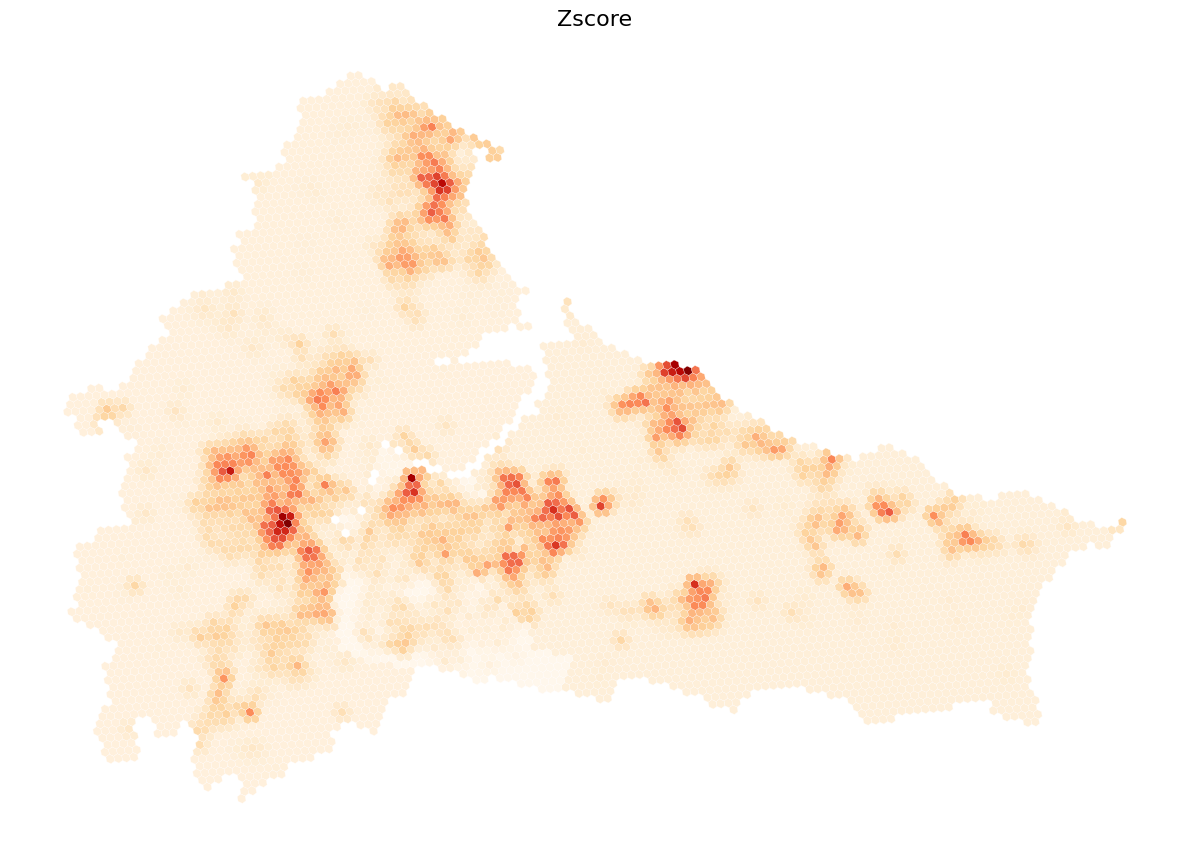

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))

hex_stats.plot(
    column="weight_plus_mean_sqrt_zscore_by_geo_boundary",
    cmap="OrRd",      
    legend=False,      
    edgecolor="white",
    linewidth=0.2,
    ax=ax
)

ax.set_title("Zscore", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

## B. Hexseg workflow: Segments

### 1. count_crimes_by_nearest_road

* Assign crime counts to street segments by nearest, up to user defined distance

In [13]:
roads_with_counts = hexseg.count_crimes_by_nearest_road(
    crimes_gdf=gdf_crimes,
    roads_gdf=gdf_roads,
    max_dist=75
    )

### 2. build_adj_graph

* Build edges and nodes for street segments to ensure contiguity when clustering

In [14]:
G = hexseg.build_adj_graph(roads_with_counts,
                          fid_col=None,
                          crime_count_col='crime_count')

### 3. segment_clusters

* Clusters street segments together, user can define min/max number of street segments to be clustered, and minimum crimes to be within a single cluster

In [15]:
clusters = hexseg.segment_clusters(G, min_size=2, max_size=10, min_crimes=50)

### 4. clusters_to_gdf

* Assign clusters and sum of crime in clusters to a gdf for plotting

In [16]:
gdf_clusters = hexseg.clusters_to_gdf(clusters, G, roads_with_counts, fid_col='fid', crime_count_col='crime_count')

In [17]:
gdf_clusters

,cluster_id,fid,cluster_crime_sum,crime_count,geometry
0,1,28545,516,0,"MULTILINESTRING ((449202 520791, 449196.04 520..."
1,1,26530,516,0,"MULTILINESTRING ((449515 520749, 449540.99 520..."
2,1,7459,516,0,"MULTILINESTRING ((449454.4 520751.4, 449468.73..."
3,1,13415,516,4,"MULTILINESTRING ((449202 520791, 449251 520791))"
4,1,8846,516,24,"MULTILINESTRING ((449368 520752, 449383.09 520..."
...,...,...,...,...,...
23475,2348,31029,62,2,"MULTILINESTRING ((445473 517680, 445562.01 517..."
23476,2348,278,62,19,"MULTILINESTRING ((445476 517723, 445474.5 5177..."
23477,2348,1176,62,0,"MULTILINESTRING ((445591 517689, 445589 517728))"
23478,2348,33465,62,0,"MULTILINESTRING ((445591 517689, 445604.99 517..."


## C. Visualising results 

### create_folium_map

* Add the hexagons and segment lines of interest to a folium map to explore

## C. Visualising results

In [21]:
m = hexseg.create_folium_map(
      hex_gdf=hex_stats,
      hex_query="weight_plus_mean_sqrt_rank_by_geo_boundary <= 75",
      seg_gdf=gdf_clusters,
      seg_query="cluster_crime_sum > 125",
      district_gdf=gdf_districts,
      district_query=None) 
      
m